## Traininig of the Particle Sequence classifier

**4.2 Particle Sequence classifier** This trains the Particle Sequence classifier model using BigDL and Analytics Zoo

To run this notebook we used the following configuration:
* *Software stack*: Spark 2.4.3, analytics-zoo 0.5.1
* *Platform*: CentOS 7, Python 3.6
* *Spark cluster*: Analytix

In [1]:
# pip install pyspark or use your favorite way to set Spark Home, here we use findspark
import findspark
findspark.init('/home/luca/Spark/spark-2.4.3-bin-hadoop2.7') #set path to SPARK_HOME

In [2]:
# Configure according to your environment
from pyspark.sql import SparkSession

pyspark_python = "<path to python>/bin/python"
analytics_zoo_jar = "<path>/analytics-zoo-bigdl_0.8.0-spark_2.4.3-0.5.1-jar-with-dependencies.jar"
analytics_zoo_python_api = "<path>/analytics-zoo-bigdl_0.8.0-spark_2.4.3-0.5.1-python-api.zip"

spark = SparkSession.builder \
        .appName("4.2-Training-ParticleSequenceClassifier") \
        .master("yarn") \
        .config("spark.driver.memory","8g") \
        .config("spark.executor.memory","14g") \
        .config("spark.executor.cores","6") \
        .config("spark.executor.instances","70") \
        .config("spark.dynamicAllocation.enabled","false") \
        .config("spark.shuffle.reduceLocality.enabled","false") \
        .config("spark.shuffle.blockTransferService","nio") \
        .config("spark.scheduler.minRegisteredResourcesRatio","1.0") \
        .config("spark.speculation","false") \
        .config("spark.eventLog.enabled","false") \
        .config("spark.jars",analytics_zoo_jar) \
        .config("spark.submit.pyFiles",analytics_zoo_python_api) \
        .config("spark.pyspark.python",pyspark_python) \
        .getOrCreate()

In [3]:
# Check if Spark Session has been created correctly
spark

## Load train and test dataset

In [4]:
PATH = "hdfs://analytix/Training/Spark/TopologyClassifier/"

trainDF = spark.read.format('parquet')\
        .load(PATH + 'trainUndersampled.parquet')\
        .select(['GRU_input', 'encoded_label'])
        
testDF = spark.read.format('parquet')\
        .load(PATH + 'testUndersampled.parquet')\
        .select(['GRU_input', 'encoded_label'])

In [5]:
trainDF.printSchema()

root
 |-- GRU_input: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: double (containsNull = true)
 |-- encoded_label: vector (nullable = true)



In [6]:
print("Number of events in the test dataset:", testDF.count())

print("Number of events in the training dataset:", trainDF.count())

Number of events in the test dataset: 856090
Number of events in the training dataset: 3426083


## Create the model

In [7]:
# Init analytics zoo
from zoo.common.nncontext import *
sc = init_nncontext("Particle Sequence Classifier")

In [8]:
# Create Keras-like zoo model.
# Only need to change package name from keras to zoo.pipeline.api.keras
from zoo.pipeline.api.keras.optimizers import Adam
from zoo.pipeline.api.keras.models import Sequential
from zoo.pipeline.api.keras.layers.core import *
from zoo.pipeline.api.keras.layers.recurrent import GRU

model = Sequential()
model.add(Masking(0.0, input_shape=(801, 19)))
model.add(GRU(        
        output_dim=50,
        activation='tanh'
        ))
model.add(Dropout(0.2)) 
model.add(Dense(3, activation='softmax'))

creating: createZooKerasSequential
creating: createZooKerasMasking
creating: createZooKerasGRU
creating: createZooKerasDropout
creating: createZooKerasDense


## Create train and validation DataFrame

No need to change to RDD of Sample, just use dataframe. But we need to flatten multi-dimension array before training.

In [9]:
import itertools
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, DoubleType

flat = udf(lambda particles : list(itertools.chain.from_iterable(particles)), ArrayType(DoubleType()))

In [10]:
trainDF = trainDF.withColumn("GRU_input_flat", flat('GRU_input'))
trainDF.printSchema()

root
 |-- GRU_input: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: double (containsNull = true)
 |-- encoded_label: vector (nullable = true)
 |-- GRU_input_flat: array (nullable = true)
 |    |-- element: double (containsNull = true)



In [11]:
testDF = testDF.withColumn("GRU_input_flat", flat('GRU_input'))
testDF.printSchema()

root
 |-- GRU_input: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: double (containsNull = true)
 |-- encoded_label: vector (nullable = true)
 |-- GRU_input_flat: array (nullable = true)
 |    |-- element: double (containsNull = true)



## Optimizer setup and training

In [12]:
# Set of hyperparameters
numEpochs = 50

# The batch used by BDL must be a multiple of numExecutors * executorCores
# Because data will be equally distibuted inside each executor

workerBatch = 32

numExecutors = int(spark.conf.get('spark.executor.instances'))

executorCores = int(spark.conf.get('spark.executor.cores'))

BDLbatch = workerBatch * numExecutors * executorCores

In [13]:
# Create SparkML compatible estimator for deep learning training

from bigdl.optim.optimizer import EveryEpoch, Loss, TrainSummary, ValidationSummary
from zoo.pipeline.nnframes import *
from zoo.pipeline.api.keras.objectives import CategoricalCrossEntropy

# Since we flat the array before, we need to set original input array shape in feature_preprocessing transformer
# for estimator
estimator = NNEstimator(model=model, criterion=CategoricalCrossEntropy(), feature_preprocessing=[801,19])\
        .setOptimMethod(Adam()) \
        .setBatchSize(BDLbatch) \
        .setMaxEpoch(numEpochs) \
        .setFeaturesCol("GRU_input_flat") \
        .setLabelCol("encoded_label") \
        .setValidation(trigger=EveryEpoch() , val_df=testDF,
                       val_method=[Loss(CategoricalCrossEntropy())], batch_size=BDLbatch)

creating: createZooKerasCategoricalCrossEntropy
creating: createSeqToTensor
creating: createSeqToTensor
creating: createFeatureLabelPreprocessing
creating: createNNEstimator
creating: createZooKerasAdam
creating: createDefault
creating: createEveryEpoch
creating: createZooKerasCategoricalCrossEntropy
creating: createLoss


Let's define a directory to store logs (i.e. train and validation losses) and save models

In [14]:
# name of our application
appName = "ParticleSequenceClassifier"

# Change it! 
logDir = "/tmp"

# Check if there is already an application with the same name 
# and remove it, otherwise logs will be appended to that app
import os
try:
    os.system('rm -rf '+logDir+'/'+appName)
except:
    pass

print("Saving logs to {}".format(logDir+'/'+appName))

Saving logs to /tmp/ParticleSequenceClassifier


In [15]:
trainSummary = TrainSummary(log_dir=logDir,app_name=appName)
estimator.setTrainSummary(trainSummary)

valSummary = ValidationSummary(log_dir=logDir,app_name=appName)
estimator.setValidationSummary(valSummary)

creating: createTrainSummary
creating: createValidationSummary


NNEstimator_6fb9140d832c

We are now ready to launch the training.

Warning for CERN SWAN users: During the training it would be better to shutdown the Toggle Spark Monitoring Display because each iteration is seen as a spark job, therefore the toggle will try to display everything causing problem to the browser. 

In [16]:
%time trained_model = estimator.fit(trainDF)

creating: createToTuple
creating: createChainedPreprocessing
CPU times: user 2.97 s, sys: 1.6 s, total: 4.57 s
Wall time: 9h 25min 27s


## Plot loss

<IPython.core.display.Javascript object>


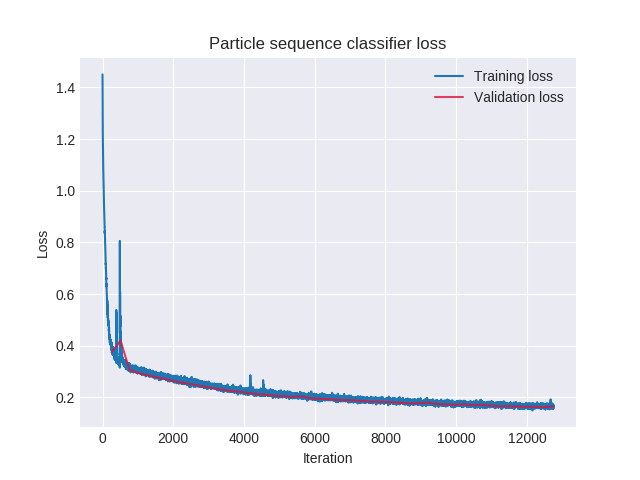

In [17]:
%matplotlib notebook

import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

loss = np.array(trainSummary.read_scalar("Loss"))
val_loss = np.array(valSummary.read_scalar("Loss"))

plt.plot(loss[:,0], loss[:,1], label="Training loss")
plt.plot(val_loss[:,0], val_loss[:,1], label="Validation loss", color='crimson', alpha=0.8)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.title("Particle sequence classifier loss")
plt.show()

## Save the model

In [18]:
modelDir = logDir + '/models'
trained_model.save(modelDir + '/ParticleSequenceClassifier')

NNModel_a2d1f4d89da9

**Note:** It is possible to load the model in the following way:
```Python
from zoo.pipeline.nnframes import *
trained_model = NNModel.load(path=modelPath+'ParticleSequenceClassifier')
```

In [21]:
# from zoo.pipeline.nnframes import *
# modelDir='/tmp/models/'
# trained_model = NNModel.load(path=modelDir+'ParticleSequenceClassifier')

## Prediction

In [19]:
# Predict with trained NNModel using pipeline transform API
predDF = trained_model.transform(testDF)

In [20]:
y_pred = np.asarray(predDF.select("prediction").collect())
y_true = np.asarray(testDF.select('encoded_label').rdd\
                    .map(lambda row: np.asarray(row.encoded_label)).collect())

In [21]:
y_pred = np.squeeze(y_pred)
y_pred.shape

(856090, 3)

In [22]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

<IPython.core.display.Javascript object>


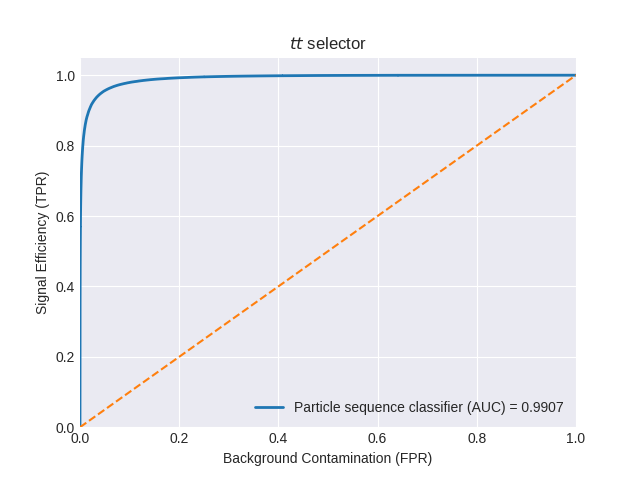

In [23]:
%matplotlib notebook

import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
plt.figure()
plt.plot(fpr[0], tpr[0], lw=2, 
         label='Particle sequence classifier (AUC) = %0.4f' % roc_auc[0])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Contamination (FPR)')
plt.ylabel('Signal Efficiency (TPR)')
plt.title('$tt$ selector')
plt.legend(loc="lower right")
plt.show();

## Confusion Matrix

In [24]:
from sklearn.metrics import accuracy_score

print('Accuracy of the Inclusive classifier: {:.4f}'.format(
    accuracy_score(np.argmax(y_true, axis=1),np.argmax(y_pred, axis=1))))

Accuracy of the Inclusive classifier: 0.9394


<IPython.core.display.Javascript object>


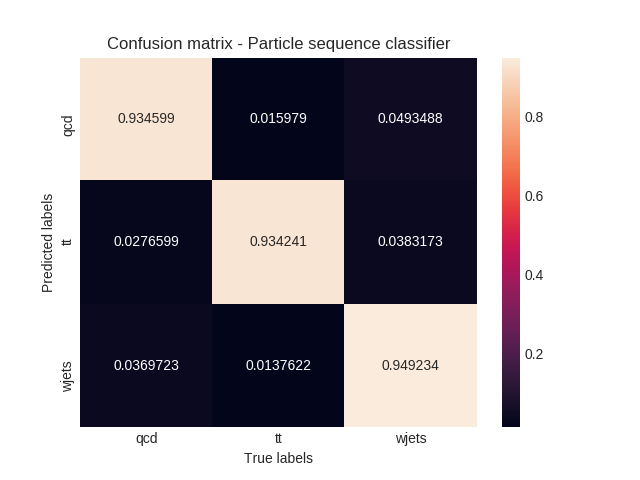

In [25]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
labels_name = ['qcd', 'tt', 'wjets']
labels = [0,1,2]

cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), labels=labels)

## Normalize CM
cm = cm / cm.astype(np.float).sum(axis=1)

fig, ax = plt.subplots()
ax = sns.heatmap(cm, annot=True, fmt='g')
ax.xaxis.set_ticklabels(labels_name)
ax.yaxis.set_ticklabels(labels_name)
plt.title('Confusion matrix - Particle sequence classifier')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [29]:
spark.stop()